# Chapter 8. Conditional Manatees

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro as npyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, log_likelihood
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")

### Code 8.1

In [2]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged

# make log version of outcome
d["log_gdp"] = d["rgdppc_2000"].pipe(onp.log)

# extract countries with GDP data
dd = d[d["rgdppc_2000"].notnull()].copy()

# rescale variables
dd["log_gdp_std"] = dd.log_gdp / dd.log_gdp.mean()
dd["rugged_std"] = dd.rugged / dd.rugged.max()

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]  # Africa
d_A0 = dd[dd["cont_africa"] == 0]  # not Africa

### Code 8.2

In [3]:
def model(rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 1))
    b = npyro.sample("b", dist.Normal(0, 1))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + b * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_1, optim.Adam(0.1), AutoContinuousELBO(),
          rugged_std=d_A1.rugged_std.values,
          log_gdp_std=d_A1.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_1 = svi.get_params(state)

### Code 8.3

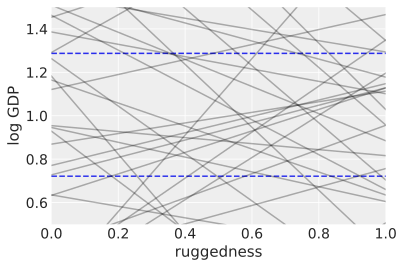

In [4]:
predictive = Predictive(m8_1.model, num_samples=1000,
                        return_sites=["a", "b", "sigma"])
prior = predictive.get_samples(PRNGKey(7), rugged_std=0)

# set up the plot dimensions
plt.subplot(xlim=(0, 1), ylim=(0.5, 1.5),
            xlabel="ruggedness", ylabel="log GDP")
plt.gca().axhline(dd.log_gdp_std.min(), ls="--")
plt.gca().axhline(dd.log_gdp_std.max(), ls="--")

# draw 50 lines from the prior
rugged_seq = np.linspace(-0.1, 1.1, num=30)
mu = Predictive(m8_1.model, prior, return_sites=["mu"]).get_samples(
    PRNGKey(7), rugged_std=rugged_seq)["mu"]
for i in range(50):
    plt.plot(rugged_seq, mu[i], "k", alpha=0.3)

### Code 8.4

In [5]:
np.sum(np.abs(prior["b"]) > 0.6) / prior["b"].shape[0]

DeviceArray(0.564, dtype=float32)

### Code 8.5

In [6]:
def model(rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 0.1))
    b = npyro.sample("b", dist.Normal(0, 0.3))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + b * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_1, optim.Adam(0.1), AutoContinuousELBO(),
          rugged_std=d_A1.rugged_std.values,
          log_gdp_std=d_A1.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_1 = svi.get_params(state)

### Code 8.6

In [7]:
# Non-African nations
def model(rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 0.1))
    b = npyro.sample("b", dist.Normal(0, 0.25))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + b * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_2, optim.Adam(0.1), AutoContinuousELBO(),
          rugged_std=d_A0.rugged_std.values,
          log_gdp_std=d_A0.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_2 = svi.get_params(state)

### Code 8.7

In [8]:
def model(rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 0.1))
    b = npyro.sample("b", dist.Normal(0, 0.3))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + b * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_3, optim.Adam(0.1), AutoContinuousELBO(),
          rugged_std=dd.rugged_std.values, log_gdp_std=dd.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_3 = svi.get_params(state)

### Code 8.8

In [9]:
# make variable to index Africa (0) or not (1)
dd["cid"] = np.where(dd.cont_africa.values == 1, 0, 1)

### Code 8.9

In [10]:
def model(cid, rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 0.1), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.3))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_4, optim.Adam(0.1), AutoContinuousELBO(),
          cid=dd.cid.values, rugged_std=dd.rugged_std.values,
          log_gdp_std=dd.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_4 = svi.get_params(state)

### Code 8.10

In [11]:
post = m8_3.sample_posterior(PRNGKey(2), p8_3, (1000,))
logprob = log_likelihood(m8_3.model, post, rugged_std=dd.rugged_std.values,
                         log_gdp_std=dd.log_gdp_std.values)["log_gdp_std"]
az8_3 = az.from_dict(sample_stats={"log_likelihood": logprob[None, ...]})
post = m8_4.sample_posterior(PRNGKey(2), p8_4, (1000,))
logprob = log_likelihood(
    m8_4.model, post, rugged_std=dd.rugged_std.values,
    cid=dd.cid.values, log_gdp_std=dd.log_gdp_std.values)["log_gdp_std"]
az8_4 = az.from_dict(sample_stats={"log_likelihood": logprob[None, ...]})
az.compare({"m8.3": az8_3, "m8.4": az8_4})

See http://arxiv.org/abs/1507.04544 for details


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8.4,0,-252.36,4.15397,0,0.999996,12.6471,0,True,deviance
m8.3,1,-188.818,2.65328,63.5417,4.23302e-06,15.7034,14.9594,False,deviance


### Code 8.11

In [12]:
post = m8_4.sample_posterior(PRNGKey(1), p8_4, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.88      0.02      0.88      0.86      0.90   1049.96      1.00
      a[1]      1.05      0.01      1.05      1.03      1.07    824.00      1.00
         b     -0.05      0.05     -0.05     -0.13      0.02    999.08      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    961.35      1.00



### Code 8.12

In [13]:
rugged_seq = np.linspace(start=-1, stop=1.1, num=30)

# compute mu over samples, fixing cid=1
predictive = Predictive(m8_4.model, post, return_sites=["mu"])
mu_NotAfrica = predictive.get_samples(
    PRNGKey(2), cid=1, rugged_std=rugged_seq)["mu"]

# compute mu over samples, fixing cid=0
mu_Africa = predictive.get_samples(
    PRNGKey(2), cid=0, rugged_std=rugged_seq)["mu"]

# summarize to means and intervals
mu_NotAfrica_mu = np.mean(mu_NotAfrica, 0)
mu_NotAfrica_ci = np.percentile(mu_NotAfrica, q=(1.5, 98.5), axis=0)
mu_Africa_mu = np.mean(mu_Africa, 0)
mu_Africa_ci = np.percentile(mu_Africa, q=(1.5, 98.5), axis=0)

### Code 8.13

In [14]:
def model(cid, rugged_std, log_gdp_std=None):
    a = npyro.sample("a", dist.Normal(1, 0.1), sample_shape=(2,))
    b = npyro.sample("b", dist.Normal(0, 0.3), sample_shape=(2,))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("log_gdp_std", dist.Normal(mu, sigma), obs=log_gdp_std)

m8_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_5, optim.Adam(0.1), AutoContinuousELBO(),
          cid=dd.cid.values, rugged_std=dd.rugged_std.values,
          log_gdp_std=dd.log_gdp_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_5 = svi.get_params(state)

### Code 8.14

In [15]:
post = m8_5.sample_posterior(PRNGKey(1), p8_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.89      0.02      0.89      0.86      0.91   1009.20      1.00
      a[1]      1.05      0.01      1.05      1.04      1.07    755.33      1.00
      b[0]      0.13      0.07      0.13      0.01      0.24   1045.06      1.00
      b[1]     -0.15      0.06     -0.14     -0.23     -0.05   1003.36      1.00
     sigma      0.11      0.01      0.11      0.10      0.12    810.01      1.00



### Code 8.15

In [16]:
post = m8_3.sample_posterior(PRNGKey(2), p8_3, (1000,))
logprob = log_likelihood(m8_3.model, post, rugged_std=dd.rugged_std.values,
                         log_gdp_std=dd.log_gdp_std.values)["log_gdp_std"]
az8_3 = az.from_dict(sample_stats={"log_likelihood": logprob[None, ...]})
post = m8_4.sample_posterior(PRNGKey(2), p8_4, (1000,))
logprob = log_likelihood(
    m8_4.model, post, rugged_std=dd.rugged_std.values,
    cid=dd.cid.values, log_gdp_std=dd.log_gdp_std.values)["log_gdp_std"]
az8_4 = az.from_dict(sample_stats={"log_likelihood": logprob[None, ...]})
post = m8_5.sample_posterior(PRNGKey(2), p8_5, (1000,))
logprob = log_likelihood(
    m8_5.model, post, rugged_std=dd.rugged_std.values,
    cid=dd.cid.values, log_gdp_std=dd.log_gdp_std.values)["log_gdp_std"]
az8_5 = az.from_dict(sample_stats={"log_likelihood": logprob[None, ...]})
az.compare({"m8.3": az8_3, "m8.4": az8_4, "m8.5": az8_5})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m8.5,0,-259.176,5.10358,0,0.817678,12.8532,0,True,deviance
m8.4,1,-252.36,4.15397,6.81646,0.182317,15.7544,6.6764,True,deviance
m8.3,2,-188.818,2.65328,70.3582,4.43854e-06,15.7014,15.3431,False,deviance


### Code 8.16

In [17]:
waic_list = az.waic(az8_5, pointwise=True).waic_i.values

### Code 8.17

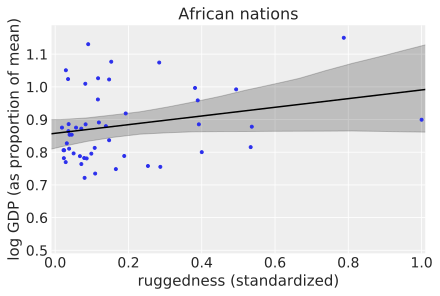

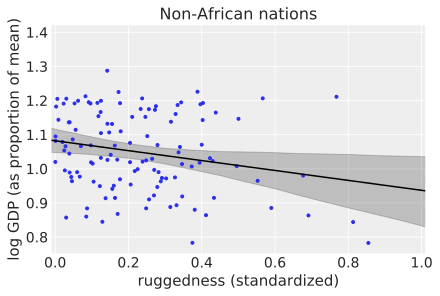

In [18]:
# plot Africa - cid=0
az.plot_pair(d_A1[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylabel="log GDP (as proportion of mean)")
post = m8_5.sample_posterior(PRNGKey(1), p8_5, (1000,))
predictive = Predictive(m8_5.model, post, return_sites=["mu"])
mu = predictive.get_samples(PRNGKey(2), cid=0, rugged_std=rugged_seq)["mu"]
mu_mean = np.mean(mu, 0)
mu_ci = np.percentile(mu, q=(1.5, 98.5), axis=0)
plt.plot(rugged_seq, mu_mean, "k")
plt.fill_between(rugged_seq, mu_ci[0], mu_ci[1], color="k", alpha=0.2)
plt.title("African nations")
plt.show()

# plot Africa - cid=1
az.plot_pair(d_A0[["rugged_std", "log_gdp_std"]].to_dict(orient="list"))
plt.gca().set(xlim=(-0.01, 1.01), xlabel="ruggedness (standardized)",
              ylabel="log GDP (as proportion of mean)")
mu = predictive.get_samples(PRNGKey(2), cid=1, rugged_std=rugged_seq)["mu"]
mu_mean = np.mean(mu, 0)
mu_ci = np.percentile(mu, q=(1.5, 98.5), axis=0)
plt.plot(rugged_seq, mu_mean, "k")
plt.fill_between(rugged_seq, mu_ci[0], mu_ci[1], color="k", alpha=0.2)
plt.title("Non-African nations");

### Code 8.18

In [19]:
rugged_seq = np.linspace(start=-0.2, stop=1.2, num=30)
post = m8_5.sample_posterior(PRNGKey(1), p8_5, (1000,))
predictive = Predictive(m8_5.model, post, return_sites=["mu"])
muA = predictive.get_samples(PRNGKey(2), cid=0, rugged_std=rugged_seq)["mu"]
muN = predictive.get_samples(PRNGKey(2), cid=1, rugged_std=rugged_seq)["mu"]
delta = muA - muN

### Code 8.19

In [20]:
tulips = pd.read_csv("../data/tulips.csv", sep=";")
d = tulips
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 992.0+ bytes


,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


### Code 8.20

In [21]:
d["blooms_std"] = d.blooms / d.blooms.max()
d["water_cent"] = d.water - d.water.mean()
d["shade_cent"] = d.shade - d.shade.mean()

### Code 8.21

In [22]:
a = dist.Normal(0.5, 1).sample(PRNGKey(0), (int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

DeviceArray(0.6182, dtype=float32)

### Code 8.22

In [23]:
a = dist.Normal(0.5, 0.25).sample(PRNGKey(0), (int(1e4),))
np.sum((a < 0) | (a > 1)) / a.shape[0]

DeviceArray(0.0471, dtype=float32)

### Code 8.23

In [24]:
def model(water_cent, shade_cent, blooms_std=None):
    a = npyro.sample("a", dist.Normal(0.5, 0.25))
    bw = npyro.sample("bw", dist.Normal(0, 0.25))
    bs = npyro.sample("bs", dist.Normal(0, 0.25))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bw * water_cent + bs * shade_cent
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("blooms_std", dist.Normal(mu, sigma), obs=blooms_std)

m8_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_6, optim.Adam(1), AutoContinuousELBO(),
          shade_cent=d.shade_cent.values, water_cent=d.water_cent.values,
          blooms_std=d.blooms_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_6 = svi.get_params(state)

### Code 8.24

In [25]:
def model(water_cent, shade_cent, blooms_std):
    a = npyro.sample("a", dist.Normal(0.5, 0.25))
    bw = npyro.sample("bw", dist.Normal(0, 0.25))
    bs = npyro.sample("bs", dist.Normal(0, 0.25))
    bws = npyro.sample("bws", dist.Normal(0, 0.25))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent
    npyro.sample("blooms_std", dist.Normal(mu, sigma), obs=blooms_std)

m8_7 = AutoLaplaceApproximation(model)
svi = SVI(model, m8_7, optim.Adam(1), AutoContinuousELBO(),
          shade_cent=d.shade_cent.values, water_cent=d.water_cent.values,
          blooms_std=d.blooms_std.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p8_7 = svi.get_params(state)

### Code 8.25

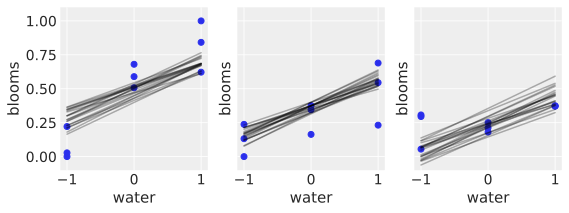

In [26]:
_, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)  # 3 plots in 1 row
for ax, s in zip(axes, range(-1, 2)):
    idx = d.shade_cent == s
    ax.scatter(d.water_cent[idx], d.blooms_std[idx])
    ax.set(xlim=(-1.1, 1.1), ylim=(-0.1, 1.1), xlabel="water", ylabel="blooms")
    post = m8_6.sample_posterior(PRNGKey(1), p8_6, (1000,))
    mu = Predictive(m8_6.model, post, return_sites=["mu"]).get_samples(
        PRNGKey(2), shade_cent=s, water_cent=np.arange(-1, 2))["mu"]
    for i in range(20):
        ax.plot(range(-1, 2), mu[i], "k", alpha=0.3)

### Code 8.26

In [27]:
predictive = Predictive(m8_6.model, num_samples=1000,
                        return_sites=["a", "bw", "bs", "bws", "sigma"])
prior = predictive.get_samples(PRNGKey(7), water_cent=0, shade_cent=0)

### Code 8.27

In [28]:
nettle = pd.read_csv("../data/nettle.csv", sep=";")
d = nettle
d["lang.per.cap"] = d["num.lang"] / d["k.pop"]